In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, TimeDistributed, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler

In [144]:
data = pd.read_csv('./bike.csv', thousands = ',')
y = pd.DataFrame(data.parkingBikeTotCnt)
y = y.dropna()

In [145]:
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

In [146]:
p1 = int(len(y) * 0.7)
p2 = int(len(y) * 0.85)

train, val, test = y[:p1], y[p1:p2], y[p2:]
print(len(train), len(val), len(test))

627 134 135


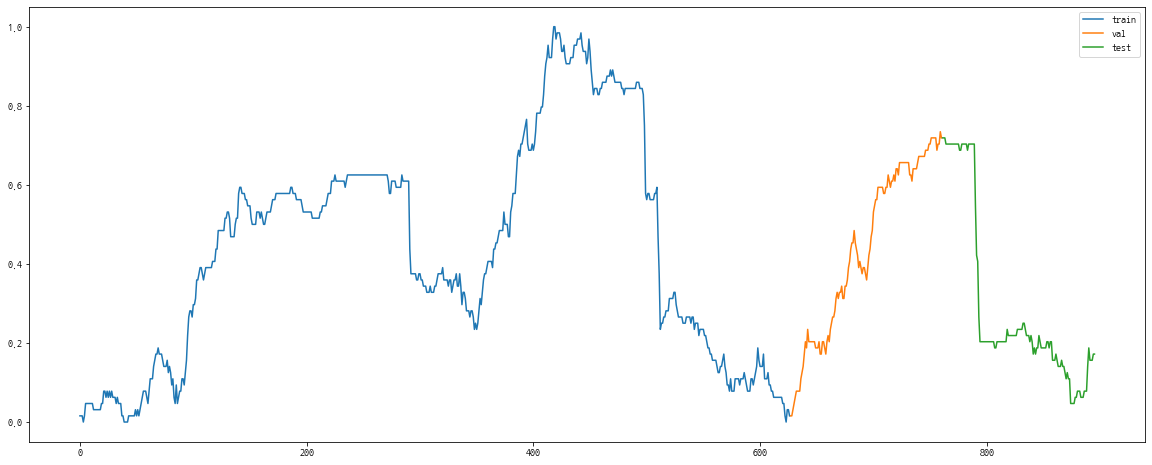

In [147]:
plt.figure(figsize=(20, 8))
plt.plot(range(0, p1), train, label="train")
plt.plot(range(p1, p2), val, label="val")
plt.plot(range(p2, len(y)), test, label="test")

plt.legend()

In [148]:
def create_dataset2(dataset, look_back=1, nPredicted = 5):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-nPredicted + 1):
		dataX.append(dataset[i:(i+look_back), 0])
		dataY.append(dataset[i + look_back: i + look_back + nPredicted, 0])
	return np.array(dataX), np.array(dataY)

In [149]:
look_back = 6
nPredicted = 6

trainX, trainY = create_dataset2(train, look_back, nPredicted)
valX, valY = create_dataset2(val, look_back, nPredicted)
testX, testY = create_dataset2(test, look_back, nPredicted)

In [150]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

trainY = np.reshape(trainY, (trainY.shape[0], trainY.shape[1], 1))
valY = np.reshape(valY, (valY.shape[0], valY.shape[1], 1))
testY = np.reshape(testY, (testY.shape[0], testY.shape[1], 1))

print(trainX.shape, trainY.shape)

(616, 6, 1) (616, 6, 1)


In [151]:
model = Sequential()  
model.add(LSTM(100, 
  batch_input_shape=(1, trainX.shape[1], trainX.shape[2]), 
  activation='linear',
  return_sequences=True,
  stateful=True,
  bias_initializer='zeros',
  kernel_initializer='zeros'
  )
)
model.add(TimeDistributed(Dense(1)))

Adam = optimizers.Adam(lr=1e-5)
model.compile(optimizer=Adam, loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (1, 6, 100)               40800     
_________________________________________________________________
time_distributed_19 (TimeDis (1, 6, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [152]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(trainX, trainY, epochs=100, batch_size=1, validation_data=(valX, valY), callbacks=[early_stop])
# model.reset_states()

Train on 616 samples, validate on 123 samples
Epoch 1/100
616/616 [==============================] - 6s 10ms/step - loss: 0.2009 - val_loss: 0.0413
Epoch 2/100
616/616 [==============================] - 3s 5ms/step - loss: 0.0694 - val_loss: 0.0143
Epoch 3/100
616/616 [==============================] - 3s 5ms/step - loss: 0.0653 - val_loss: 0.0088
Epoch 4/100
616/616 [==============================] - 3s 5ms/step - loss: 0.0640 - val_loss: 0.0073
Epoch 5/100
616/616 [==============================] - 3s 5ms/step - loss: 0.0626 - val_loss: 0.0051
Epoch 6/100
616/616 [==============================] - 3s 5ms/step - loss: 0.0602 - val_loss: 0.0044
Epoch 7/100
616/616 [==============================] - 3s 5ms/step - loss: 0.0607 - val_loss: 0.0035
Epoch 8/100
616/616 [==============================] - 3s 5ms/step - loss: 0.0564 - val_loss: 0.0032
Epoch 9/100
616/616 [==============================] - 3s 5ms/step - loss: 0.0550 - val_loss: 0.0034
Epoch 10/100
616/616 [======================

((135, 1), (124, 6))

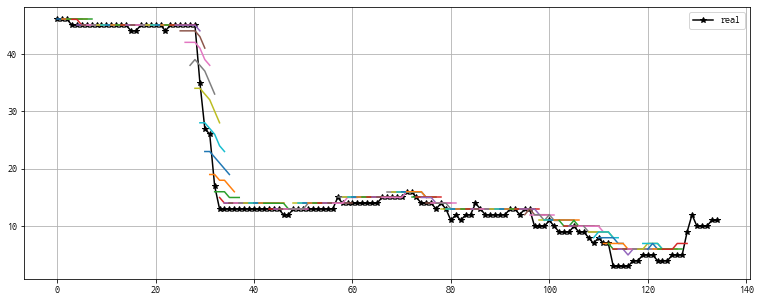

In [153]:
pred = model.predict(testX, batch_size=1)
pred = np.reshape(pred, (pred.shape[0], pred.shape[1]))
pred = scaler.inverse_transform(pred)
pred = np.around(pred)

plt.figure(figsize=(13, 5))
plt.grid(True)


real = scaler.inverse_transform(test) 
plt.plot(real, "*-", label="real", color="black")
plt.legend()

for i in range(0, len(pred), 1):
  plt.plot(range(i, i + nPredicted), pred[i])

real.shape, pred.shape

((627, 1), (616, 6))

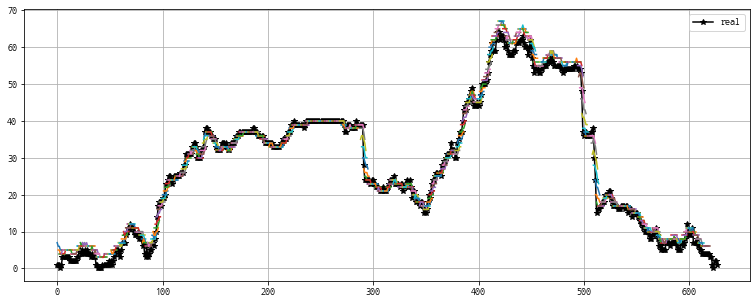

In [154]:
pred = model.predict(trainX, batch_size=1)
pred = np.reshape(pred, (pred.shape[0], pred.shape[1]))
pred = scaler.inverse_transform(pred)
pred = np.around(pred)

plt.figure(figsize=(13, 5))
plt.grid(True)


real = scaler.inverse_transform(train) 
plt.plot(real, "*-", label="real", color="black")
plt.legend()

for i in range(0, len(pred), 1):
  plt.plot(range(i, i + nPredicted), pred[i])

real.shape, pred.shape